<a href="https://colab.research.google.com/github/ds23m003/NLP/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from datasets import load_dataset,Dataset, DatasetDict
import pandas as pd


In [ ]:
emotions_train = load_dataset("csv", data_files="/train.txt", sep=";", names=["text", "label"])
emotions_valid = load_dataset("csv", data_files="/val.txt", sep=";", names=["text", "label"])
emotions_test = load_dataset("csv", data_files="/test.txt", sep=";", names=["text", "label"])


In [ ]:
emotions_train

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
})

In [ ]:
def resample_train_data(df):
    # Step 1: Separate the dataset by labels
    anger_df = df[df['label'] == 'anger']
    fear_df = df[df['label'] == 'fear']
    joy_df = df[df['label'] == 'joy']
    sadness_df = df[df['label'] == 'sadness']
    love_df = df[df['label'] == 'love']
    surprise_df = df[df['label'] == 'surprise']

    # Step 2: Randomly select 2000 entries for 'joy', 'sadness' and 'anger'
    joy_sampled = joy_df.sample(n=2000, random_state=42)
    sadness_sampled = sadness_df.sample(n=2000, random_state=42)
    anger_sampled = anger_df.sample(n=2000, random_state=42)

    # Step 3: Oversample 'love', 'surprise', and 'fear' to 2000 entries
    love_oversampled = resample(love_df,
                                replace=True,     # Sample with replacement
                                n_samples=2000,   # To match 2000
                                random_state=42)

    surprise_oversampled = resample(surprise_df,
                                    replace=True,
                                    n_samples=2000,
                                    random_state=42)

    fear_oversampled = resample(fear_df,
                                replace=True,
                                n_samples=2000,
                                random_state=42)

    # Step 5: Combine all the balanced samples into a new DataFrame
    balanced_df = pd.concat([anger_sampled, fear_oversampled, joy_sampled, sadness_sampled, love_oversampled, surprise_oversampled])

    # Step 6: Shuffle the final balanced dataset to mix the samples
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Output the result
    return balanced_df

In [ ]:
from sklearn.utils import resample
emotions_train_resampled = resample_train_data(emotions_train['train'].to_pandas())

In [ ]:
resampled_dataset = Dataset.from_pandas(emotions_train_resampled)

# Step 8: Create the DatasetDict in the required format
emotions_train = DatasetDict({
    'train': resampled_dataset
})

In [ ]:
emotions_train

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 12000
    })
})

In [ ]:
emotions_train.set_format(type="pandas")
df = emotions_train["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
emotions_train.reset_format()

In [ ]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
train_encoded = emotions_train.map(tokenize, batched=True, batch_size=None)
valid_encoded = emotions_valid.map(tokenize, batched=True, batch_size=None)
test_encoded = emotions_test.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

In [ ]:
train_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 12000
    })
})

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

In [ ]:
label_encoded = label_encoder.fit_transform(train_encoded["train"]["label"])
train_encoded["train"] = train_encoded["train"].add_column("label_encoded", label_encoded)
label_encoded = label_encoder.fit_transform(valid_encoded["train"]["label"])
valid_encoded["train"] = valid_encoded["train"].add_column("label_encoded", label_encoded)
label_encoded = label_encoder.fit_transform(test_encoded["train"]["label"])
test_encoded["train"] = test_encoded["train"].add_column("label_encoded", label_encoded)

In [ ]:
from transformers import TFAutoModelForSequenceClassification

model_ckpt = "distilbert-base-uncased"
model = TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=6)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
tokenizer_columns = tokenizer.model_input_names
tokenizer_columns

['input_ids', 'attention_mask']

In [ ]:
from transformers import DataCollatorWithPadding

tokenizer_columns = tokenizer.model_input_names

# Define a batch size
batch_size = 32

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [ ]:
tf_train_dataset = train_encoded["train"].to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["label_encoded"],
    shuffle=True,
    batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:403: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [ ]:
tf_valid_dataset = valid_encoded["train"].to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["label_encoded"],
    shuffle=True,
    batch_size=batch_size)

In [ ]:
tf_test_dataset = test_encoded["train"].to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    shuffle=False,
    batch_size=batch_size)

In [ ]:
import tensorflow as tf
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy())

In [ ]:
model.fit(tf_train_dataset, validation_data=tf_valid_dataset, epochs=5)


Epoch 1/5
375/375 [==============================] - 109s 290ms/step - loss: 0.1073 - sparse_categorical_accuracy: 0.9597 - val_loss: 0.1833 - val_sparse_categorical_accuracy: 0.9350
Epoch 2/5
375/375 [==============================] - 109s 290ms/step - loss: 0.0735 - sparse_categorical_accuracy: 0.9730 - val_loss: 0.1871 - val_sparse_categorical_accuracy: 0.9360
Epoch 3/5
375/375 [==============================] - 113s 302ms/step - loss: 0.0470 - sparse_categorical_accuracy: 0.9845 - val_loss: 0.3052 - val_sparse_categorical_accuracy: 0.9205
Epoch 4/5
375/375 [==============================] - 110s 293ms/step - loss: 0.0502 - sparse_categorical_accuracy: 0.9842 - val_loss: 0.2633 - val_sparse_categorical_accuracy: 0.9340
Epoch 5/5
375/375 [==============================] - 110s 293ms/step - loss: 0.0268 - sparse_categorical_accuracy: 0.9909 - val_loss: 0.2919 - val_sparse_categorical_accuracy: 0.9300


In [ ]:
test_encoded["train"]["input_ids"][0]

[101,
 10047,
 3110,
 2738,
 11083,
 2061,
 10047,
 2025,
 2200,
 12479,
 2157,
 2085,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
import numpy as np
output_logits = model.predict([test_encoded["train"]["input_ids"][0], test_encoded["train"]["attention_mask"][0]]).logits
pred_labels = np.argmax(output_logits)
pred_labels

1/1 [==============================] - 2s 2s/step


4

In [ ]:
pred_labels

4

In [ ]:
output_logits = model.predict(tf_test_dataset).logits
pred_labels = np.argmax(output_logits, axis=-1)

63/63 [==============================] - 8s 82ms/step


In [ ]:


from sklearn.metrics import classification_report

print(classification_report(test_encoded["train"]["label_encoded"], pred_labels))



              precision    recall  f1-score   support

           0       0.90      0.93      0.92       275
           1       0.88      0.90      0.89       224
           2       0.96      0.90      0.93       695
           3       0.74      0.89      0.81       159
           4       0.98      0.95      0.97       581
           5       0.68      0.83      0.75        66

    accuracy                           0.92      2000
   macro avg       0.86      0.90      0.88      2000
weighted avg       0.92      0.92      0.92      2000



In [ ]:
labels = list(set(test_encoded["train"]["label_encoded"]))

In [ ]:
label_names = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

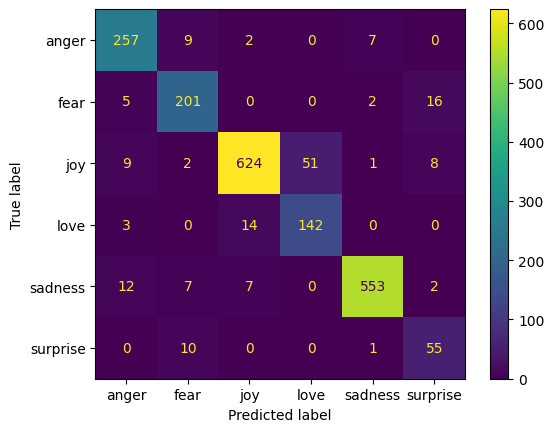

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(test_encoded["train"]["label_encoded"], pred_labels, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()

In [ ]:


for i in range(20):
    print(emotions_test["train"]["text"][i] ,"\t\t ", emotions_test["train"]["label"][i], "\t ", label_encoder.inverse_transform([pred_labels[i]]), "\n")



im feeling rather rotten so im not very ambitious right now 		  sadness 	  ['sadness'] 

im updating my blog because i feel shitty 		  sadness 	  ['sadness'] 

i never make her separate from me because i don t ever want her to feel like i m ashamed with her 		  sadness 	  ['sadness'] 

i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived 		  joy 	  ['joy'] 

i was feeling a little vain when i did this one 		  sadness 	  ['sadness'] 

i cant walk into a shop anywhere where i do not feel uncomfortable 		  fear 	  ['fear'] 

i felt anger when at the end of a telephone call 		  anger 	  ['anger'] 

i explain why i clung to a relationship with a boy who was in many ways immature and uncommitted despite the excitement i should have been feeling for getting accepted into the masters program at the university of virginia 		  joy 	  ['love'] 

i like to have the same breathless feeling as a reader eager to see what will happen next 		

In [ ]:
!nvidia-smi

Sun Oct 20 12:29:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--